### MHBF AT 
#### 10-motor-control II
##### group L
* Erfan Baradarantohidi
* Ryan Gelston
* Elizabeth Cornell Awuku


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def lqr(A, B, F, N, N_T):
    """
    Calculate the feedback gains by backpropagation of the Riccati equation
    Accept:
        F: state cost in final position, size (n,n)
        A: dynamics matrix, size (n,n)
        B: input matrix, size (n,d)
        N: cost of control, size (d,d)
        N_T: number of time steps, int.
    Returns:
        V: sequence of cost matrices, size (n,n,N_T)
        L: sequence of feedback matrix, size (d,n,N_T)
    """
    n, d = B.shape
    V = np.zeros((n,n,N_T))
    L = np.zeros((d,n,N_T))
    
    V[:,:,-1] = F
    # Run backward in time
    for t in range(N_T-2,0,-1):
        """ Your code here """
        V[:,:,t] =  A.T @ V[:,:,t+1] @ A - A.T @ V[:,:,t+1] @ B @ np.linalg.inv(N + B.T @ V[:,:,t+1] @ B) @ B.T @ V[:,:,t+1] @ A
        L[:,:,t] = np.linalg.inv(N + B.T @ V[:,:,t+1] @ B) @ B.T @ V[:,:,t+1] @ A
    return V, L

In [3]:
def simulate(x0, x0_est, A_real, A, B, C, L, 
                obs_noise, dyn_noise, init_var,dt):
    """
    Simultaneously simulate the trajectory forward and estimate the state
    Accepts:
        x0: initial position, size (n, )
        x0_est: estimate of initial position, size (n, )
        A_real: dynamics matrix - real, size (n,n)
        A: dynamics matrix - assumed, size (n,n)
        B: input matrix, size (n,d)
        C: observation matrix, size (d, n)
        L: sequence of feedback matrices, size (d, n, N_T)
        obs_noise: observation noise, float >=0
        dyn_noise: dynamics noise, float >=0
        init_var: initial variance of filter, float >=0
    Returns:
        x: true state, size (n, N_T)
        x_est: estimated state, size (n, N_T)
        x_var_est: sequence of posterior variances, size (n, n, N_T)
        kalman_gain: feedback matrices, size (n, d, N_T)
        u: controls, size (d, N_T)
    """
    # Initialize variables
    d, n, N_T = L.shape
    x = np.zeros((n,N_T))
    u = np.zeros((d,N_T-1))
    x_est = np.zeros((n,N_T))
    x_var_est = np.zeros((n,n,N_T))
    kalman_gain = np.zeros((n,d,N_T))

    x[:,0] = x0 # the true state
    x_est[:,0] = x0_est # system does not know where it is
    x_var_est[:,:,0] = init_var * np.eye(n) # very large state uncertainty at the beginning. 
    # observation noise matrix
    Q = obs_noise * dt * np.eye(d)
    # dynamics noise matrix
    R = dyn_noise * dt * np.eye(n)

    # Run forward in time
    for t in range(1, N_T):
        """ Your code here """
        # compute the control
        u[:,t-1] = -L[:,:,t-1] @ x_est[:,t-1]
        # compute the true state
        x[:,t] = A_real @ x[:,t-1] + B @ u[:,t-1] + np.random.multivariate_normal(np.zeros(n), R)
        # compute the observation
        y = C @ x[:,t] + np.random.multivariate_normal(np.zeros(d), Q)
        # compute the Kalman gain
        kalman_gain[:,:,t] = x_var_est[:,:,t-1] @ C.T @ np.linalg.inv(Q + C @ x_var_est[:,:,t-1] @ C.T)
        # compute the estimated state
        x_est[:,t] = A @ x_est[:,t-1] + B @ u[:,t-1] + kalman_gain[:,:,t] @ (y - C @ A @ x_est[:,t-1] - C @ B @ u[:,t-1])
        # compute the variance of the estimated state
        x_var_est[:,:,t] = (np.eye(n) - kalman_gain[:,:,t] @ C) @ x_var_est[:,:,t-1] @ (np.eye(n) - kalman_gain[:,:,t] @ C).T + kalman_gain[:,:,t] @ Q @ kalman_gain[:,:,t].T

    return x, x_est, x_var_est, kalman_gain, u

1. Implement the Kalman filter and the linear quadratic regulator. Initialize the Kalman filter with the correct location andvelocity, but with a very large initial estimate for the covariance matrix (What happens when you initialize the Kalman filter wrongly? Why?). Plot the true position and the estimated position as a function of time.

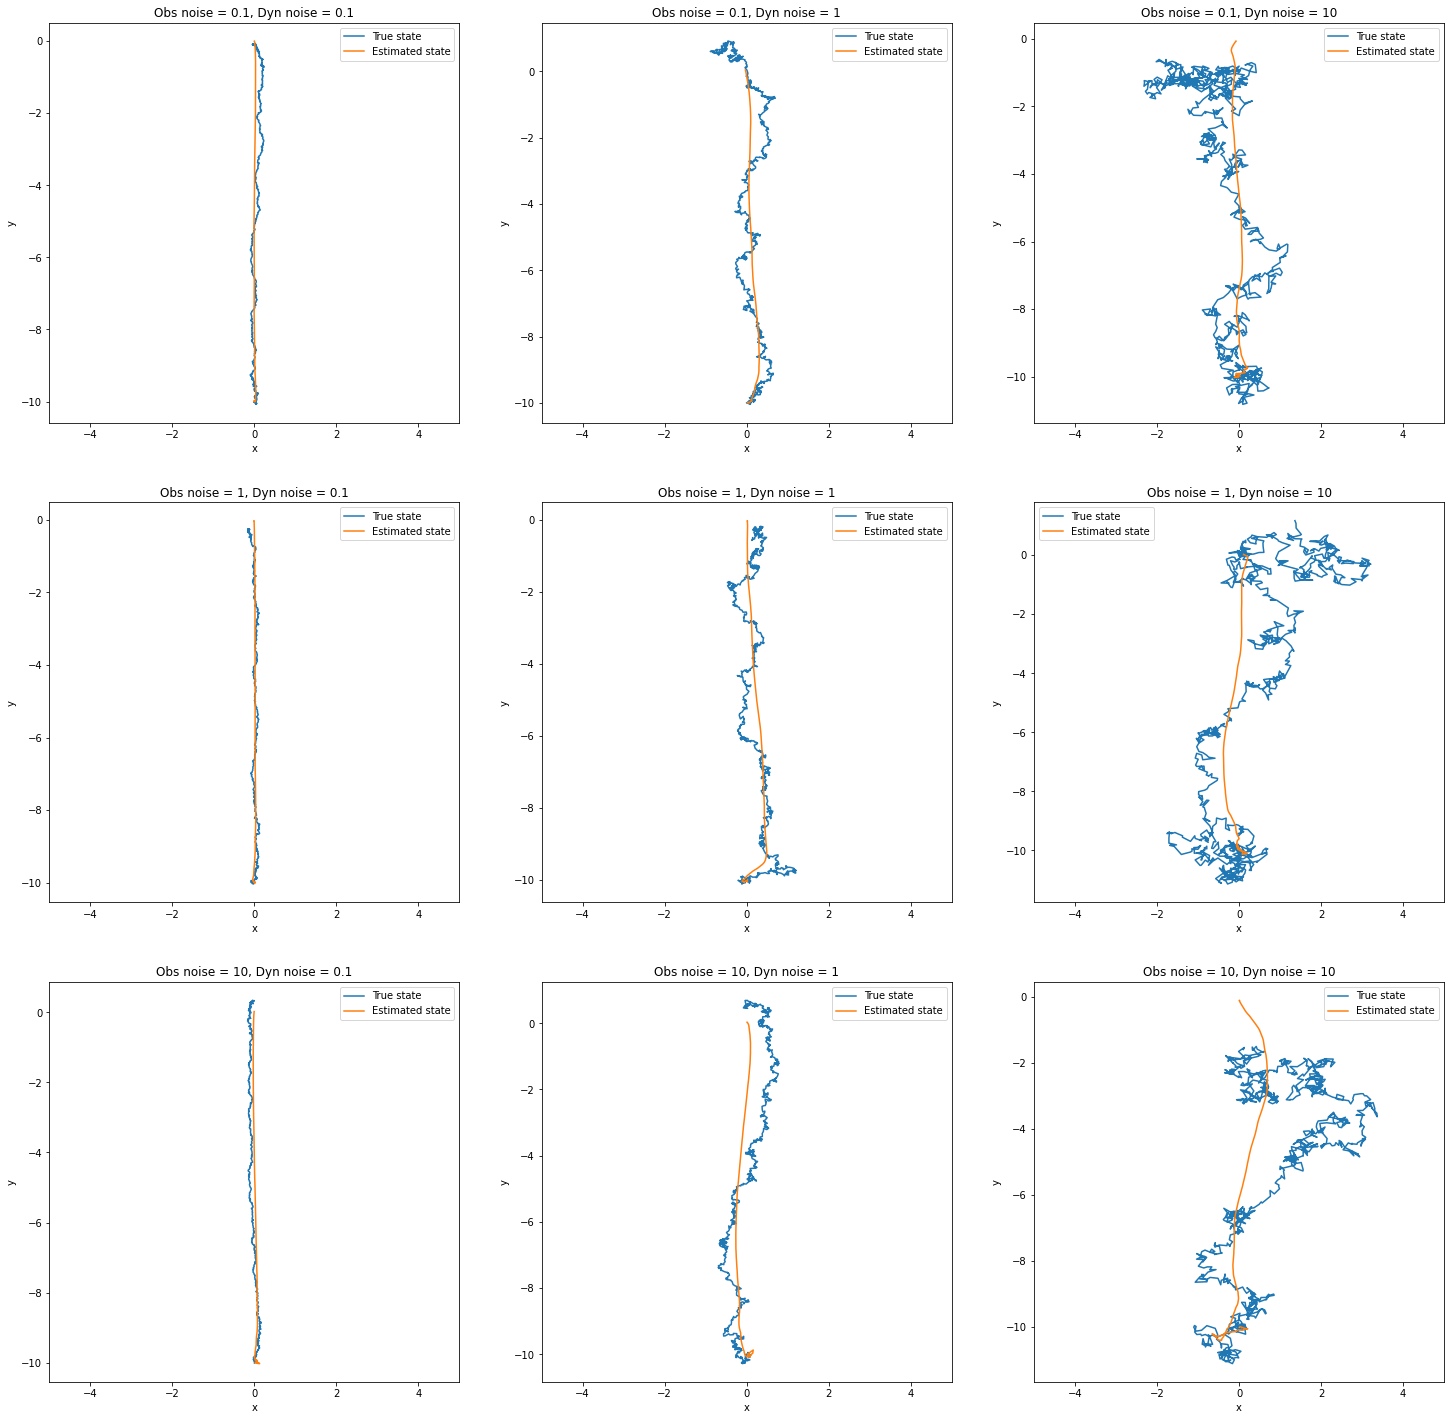

In [22]:
x0 = np.array([0,-10 , 0, 0])
m=1

dt = 0.001
T=1
N_T = int(T/dt)

#dynamics without perturbation
f0=0
A0=np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, -f0*dt/m], [0, 0, f0*dt/m, 1]])
B=np.array([[0, 0],[0, 0],[dt/m, 0],[0, dt/m]])
C=np.array([[1, 0, 0, 0],[0, 1, 0, 0]])

#final state cost matrix
F=1e+8*np.eye(4)
#control cost matrix
N=np.eye(2)

#intial state estimate same as true state
x0_est=x0+np.random.multivariate_normal(np.zeros(4), 1e-3*np.eye(4))
#initial state variance LARGE
init_var=1e+3*np.eye(4)

A_real=A0
# obs_noise = 0.01
# dyn_noise = 0.01
i=0
fig, axs = plt.subplots(3,3, figsize=(25,25))
for obs_noise in [0.1, 1, 10]:
    for dyn_noise in [0.1, 1, 10]:
        v, L = lqr(A0, B, F, N, N_T)
        x, x_est, x_var_est, kalman_gain, u = simulate(x0, x0_est, A_real, A0, B, C, L,
                                                        obs_noise, dyn_noise, init_var, dt)
        
        axs[i//3, i%3].plot(x[0,:], x[1,:], label='True state')
        axs[i//3, i%3].plot(x_est[0,:], x_est[1,:], label='Estimated state')
        axs[i//3, i%3].set_title('Obs noise = {}, Dyn noise = {}'.format(obs_noise, dyn_noise))
        axs[i//3, i%3].legend()
        axs[i//3, i%3].set_xlabel('x')
        axs[i//3, i%3].set_ylabel('y')
        axs[i//3, i%3].set_xlim([-5, 5])
        i+=1
plt.show()

* it seems that the kalman filter does a good  job regardless of obsevation noise. and the noisy dynamics still converges to a close value of desired state. but the diffrerence of true and estimated state is larger when the dynamic noise is larger.

2. Plot x 1 and x 2 both as a function of time and against each other. Plot the time
course of the velocities v 1 , v 2 . Discuss the velocity profile. Is this a good model
for human motor trajectories (see lecture)? Also, have a look at the control force.
Anything that strikes you?

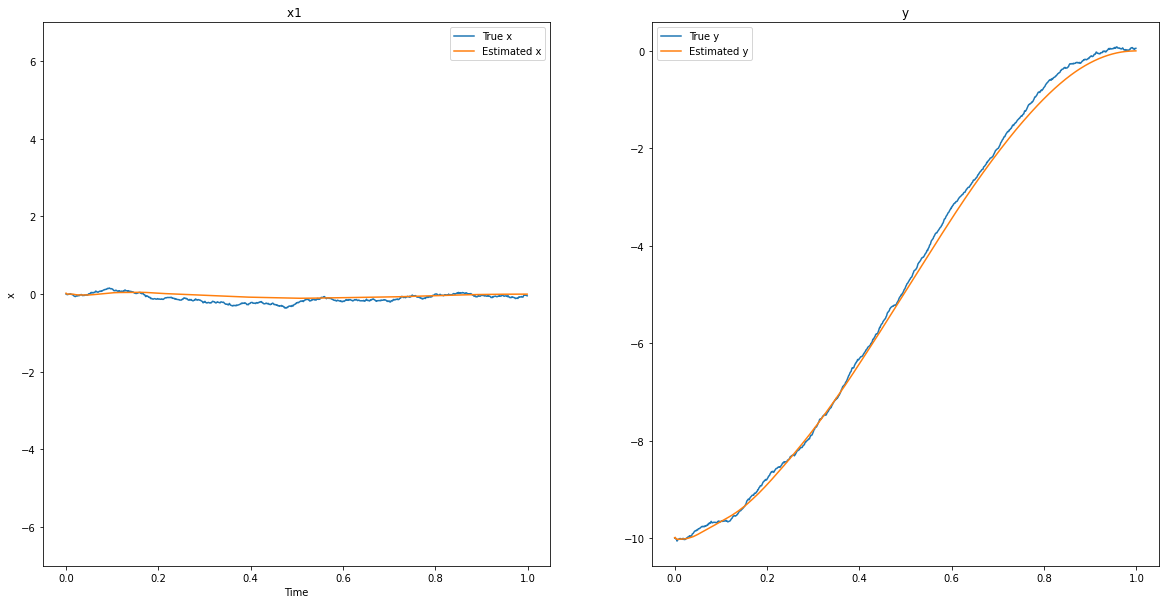

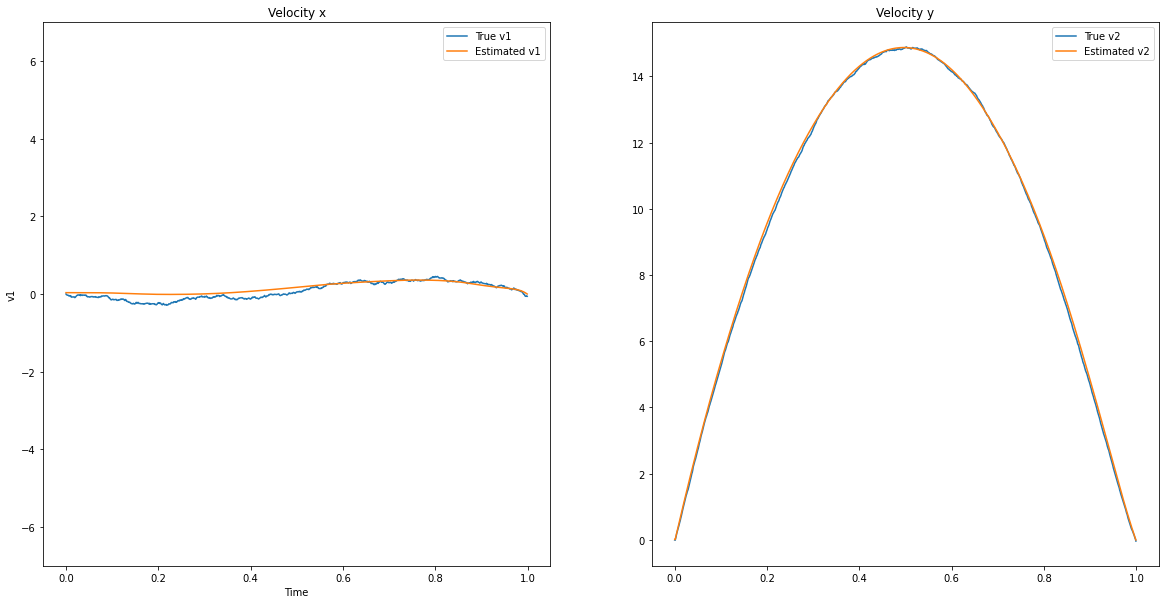

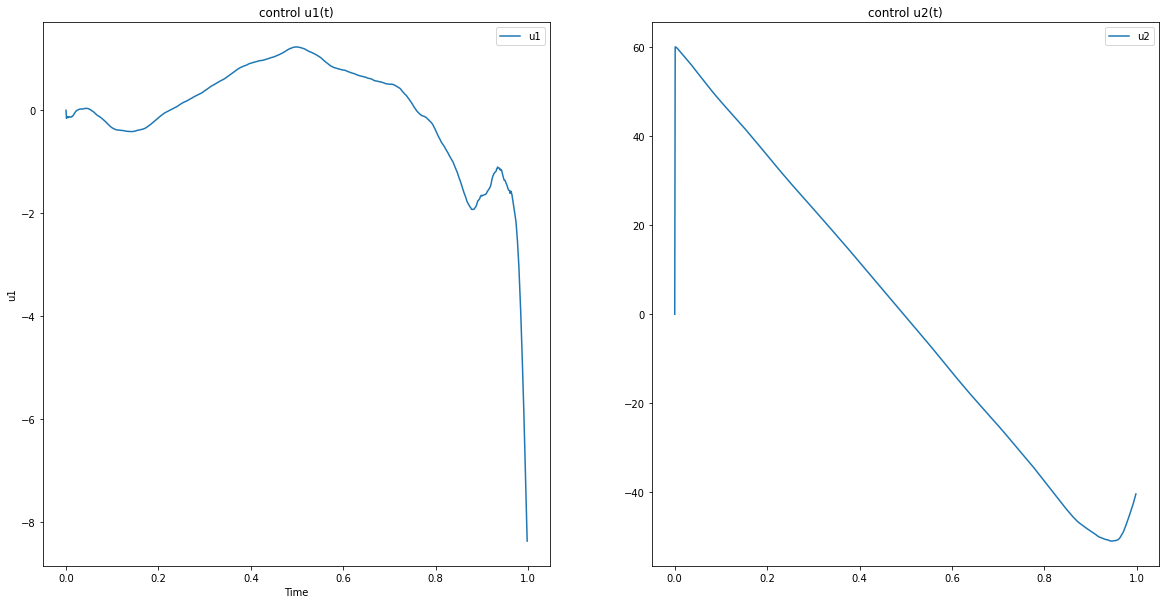

In [52]:
obs_noise = 0.1
dyn_noise = 0.1

v, L = lqr(A0, B, F, N, N_T)
x, x_est, x_var_est, kalman_gain, u = simulate(x0, x0_est, A_real, A0, B, C, L,
                                                obs_noise, dyn_noise, init_var, dt)


# x1 and x2 as a function of time
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(np.arange(N_T)*dt, x[0,:], label='True x')
axs[0].plot(np.arange(N_T)*dt, x_est[0,:], label='Estimated x')
axs[0].set_title('x1 ')
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('x')
axs[0].set_ylim([-7, 7])

axs[1].plot(np.arange(N_T)*dt, x[1,:], label='True y')
axs[1].plot(np.arange(N_T)*dt, x_est[1,:], label='Estimated y')
axs[1].set_title('y')
axs[1].legend()


fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(np.arange(N_T)*dt, x[2,:], label='True v1')
axs[0].plot(np.arange(N_T)*dt, x_est[2,:], label='Estimated v1')
axs[0].set_title('Velocity x')
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('v1')
axs[0].set_ylim([-7, 7])

axs[1].plot(np.arange(N_T)*dt, x[3,:], label='True v2')
axs[1].plot(np.arange(N_T)*dt, x_est[3,:], label='Estimated v2')
axs[1].set_title('Velocity y')
axs[1].legend()

#control force as a function of time
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(np.arange(N_T-1)*dt, u[0,:], label='u1')
axs[0].set_title('control u1(t)')
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('u1')

axs[1].plot(np.arange(N_T-1)*dt, u[1,:], label='u2')
axs[1].set_title('control u2(t)')
axs[1].legend()

* The velocity profile looks like  when we minimize the jerk. it is only happening in y direction since the we don't need to move in x direction to reach the target. 
for control force, the control force match the derivative of velocity which it should be as f=a, "a" being the acceleration.

3. introduce the perturbation force ($f_0$= 1)

(-5.0, 5.0)

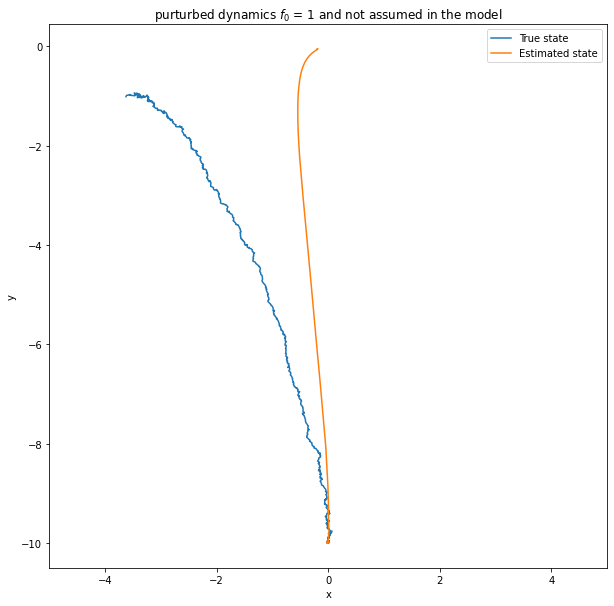

In [55]:
dyn_noise = 0.1
obs_noise = 0.1
#dynamics with perturbation
f0=1
A1=np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, -f0*dt/m], [0, 0, f0*dt/m, 1]])
A_real=A1
v, L = lqr(A0, B, F, N, N_T)
x, x_est, x_var_est, kalman_gain, u = simulate(x0, x0_est, A_real, A0, B, C, L,
                                                obs_noise, dyn_noise, init_var, dt)

plt.figure(figsize=(10,10))
plt.plot(x[0,:], x[1,:], label='True state')
plt.plot(x_est[0,:], x_est[1,:], label='Estimated state')
plt.title('purturbed dynamics $f_0$ = {} and not assumed in the model'.format(f0))
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-5, 5])

*  as modeling human feel unexpexted force, final state is not the same as the desired state. estimated to be in (0,0) but did not reach the target.

4. Assume that the perturbation force is learned

(-5.0, 5.0)

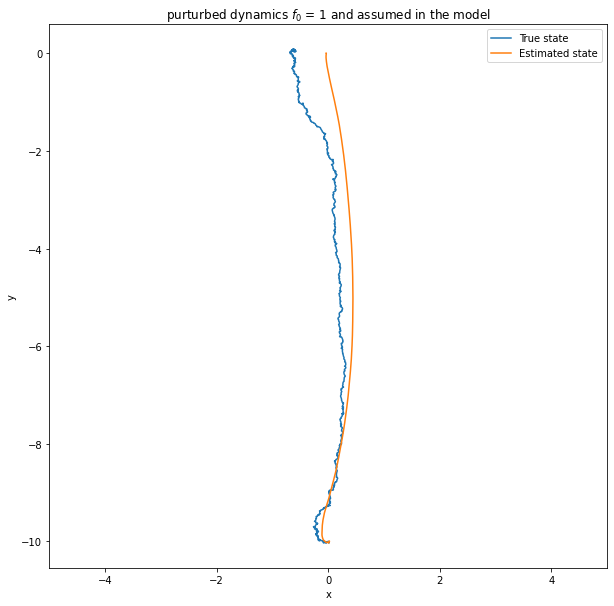

In [56]:
v, L = lqr(A1, B, F, N, N_T)
x, x_est, x_var_est, kalman_gain, u = simulate(x0, x0_est, A_real, A1, B, C, L,
                                                obs_noise, dyn_noise, init_var, dt)

plt.figure(figsize=(10,10))
plt.plot(x[0,:], x[1,:], label='True state')
plt.plot(x_est[0,:], x_est[1,:], label='Estimated state')
plt.title('purturbed dynamics $f_0$ = {} and assumed in the model'.format(f0))
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-5, 5])

* after assuming that the perturbation force is learned, the final state is close to the desired state. but not exactly the same as before.

5. remove the perturbation force but assumed in the model

(-5.0, 5.0)

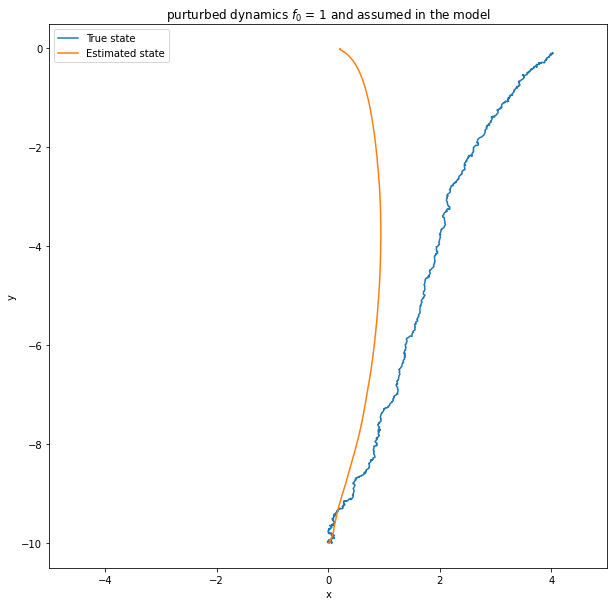

In [57]:
A_real=A0
v, L = lqr(A1, B, F, N, N_T)
x, x_est, x_var_est, kalman_gain, u = simulate(x0, x0_est, A_real, A1, B, C, L,
                                                obs_noise, dyn_noise, init_var, dt)

plt.figure(figsize=(10,10))
plt.plot(x[0,:], x[1,:], label='True state')
plt.plot(x_est[0,:], x_est[1,:], label='Estimated state')
plt.title('purturbed dynamics $f_0$ = {} and assumed in the model'.format(f0))
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-5, 5])

* in this case as expected, the final state ends up in the opposite side before the perturbation force was learned. it assumes that the perturbation force is still there but it is not and the extra force applied bring it to the other side. 